We want to analyze which landing pages generate better conversions between old_pages and new_pages

**ho: there is no significant increment conversion from the new one**

**ha: there is a significant increment conversion from the new one**


In [34]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [35]:
#from google.colab import drive
#drive.mount('/content/drive')

In [58]:
df = pd.read_csv('ab_data.csv')

In [37]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  object        
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
 5   date          294478 non-null  datetime64[ns]
 6   hour          294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 15.7+ MB


Count converted values on each landing page

In [40]:
df.groupby('landing_page')['converted'].value_counts()

landing_page  converted
new_page      0            129741
              1             17498
old_page      0            129500
              1             17739
Name: converted, dtype: int64

# check if there is duplicate data

In [59]:
df[['user_id', 'timestamp']].nunique()

user_id      290584
timestamp    294478
dtype: int64

we see that there is duplicate data,to remove duplicate data we must gather and define the double users, then define df only the actual data not the duplicate

In [62]:
session_counts = df.user_id.value_counts()
double_users = session_counts[session_counts>1].index

double_users

Int64Index([805339, 754884, 722274, 783176, 898232, 899018, 904570, 842042,
            881123, 858720,
            ...
            721188, 902463, 713355, 827417, 655283, 847058, 889392, 664150,
            835401, 736955],
           dtype='int64', length=3894)

In [63]:
df['user_id'].isin(double_users).value_counts()

False    286690
True       7788
Name: user_id, dtype: int64

In [64]:
df = df[~df['user_id'].isin(double_users)]
df.shape

(286690, 5)

after the data is clean we visualize data

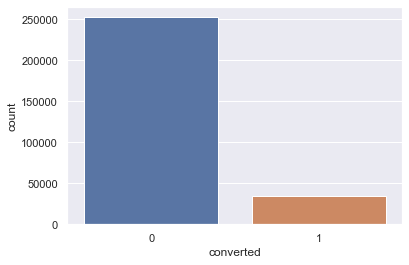

In [65]:
import seaborn as sns
sns.set(style="darkgrid")

ax = sns.countplot(x="converted", data=df)

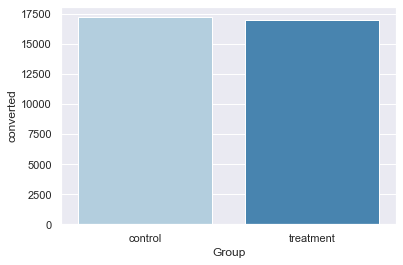

In [67]:
df=df.groupby('group')['converted'].sum().to_frame().reset_index()
sns.barplot(x = df['group'],y = df['converted'],palette = "Blues")

plt.xlabel('Group')
plt.ylabel('converted') 

plt.show()

In [9]:
df

,user_id,timestamp,group,landing_page,converted,date,hour
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21 22:11:48.556739,22
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12 08:01:45.159739,8
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11 16:55:06.154213,16
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08 18:28:03.143765,18
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21 01:52:26.210827,1
...,...,...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,2017-01-03 22:28:38.630509,22
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,2017-01-12 00:51:57.078372,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,2017-01-22 11:45:03.439544,11
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,2017-01-15 01:20:28.957438,1


# Power Analysis

assume that previous conversion was 12% then we want to increase conversion to 13 %, and we leave other parameters as default

In [46]:
effect_size = sms.proportion_effectsize(0.12, 0.13)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)


17164


Sampling Data per group then concat them into ab_test

In [47]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [49]:
treatment_sample.count()

user_id         17164
timestamp       17164
group           17164
landing_page    17164
converted       17164
date            17164
hour            17164
dtype: int64

In [50]:
control_sample.count()

user_id         17164
timestamp       17164
group           17164
landing_page    17164
converted       17164
date            17164
hour            17164
dtype: int64

In [54]:
ab_test.groupby('group')['converted'].mean()

group
control      0.122291
treatment    0.120193
Name: converted, dtype: float64

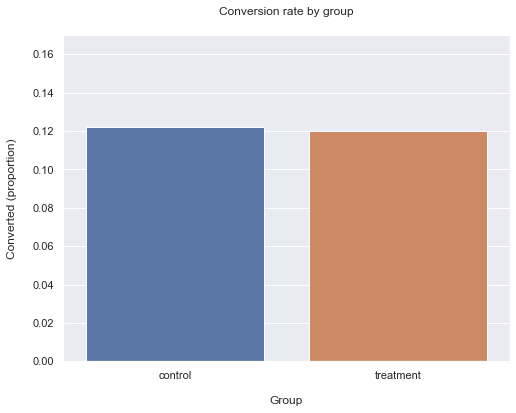

In [55]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [56]:

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [18]:
control_results

0        0
1        0
2        0
3        0
4        0
        ..
17159    0
17160    0
17161    1
17162    0
17163    0
Name: converted, Length: 17164, dtype: int64

In [19]:
treatment_results 

17164    0
17165    0
17166    0
17167    0
17168    0
        ..
34323    0
34324    0
34325    0
34326    0
34327    0
Name: converted, Length: 17164, dtype: int64

In [20]:
control_results.count()

17164

In [21]:
treatment_results.count()

17164

In [22]:
control_results.sum()

2082

In [23]:
treatment_results.sum()

2018

we define number observation as nobs and success group or total converted each group as successes

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [24]:

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.07
p-value: 0.287
ci 95% for control group: [0.116, 0.126]
ci 95% for treatment group: [0.113, 0.122]


The Result , we cant accept alternative ,it means that there is no significant increment conversion from new pages above 13% because we can see that **p-value is under 0.05 --> we cannot accept the alternative hypothesis**

and we got **95% chance probability number  conversion** for control group between **0.116 until 0.126**
then for treatment group we got **0.113 until 0.122**
then if we compare maximum conversion from both **control group  got a better conversion** than treatment